In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


In [2]:
df_train= pd.read_csv('covid_train.csv')
df_test =pd.read_csv('covid_test.csv')
df_test.head()
df_train.shape

(1001, 9)

In [3]:
X_train,y_train = df_train.drop(['Urgency'],axis=1),df_train['Urgency']
X_test ,y_test = df_test.drop(['Urgency'],axis=1),df_test['Urgency']

In [4]:
def best_classifier (clf,params,X,y,n_folds = 5):
    gs=GridSearchCV(clf,param_grid=params,cv=n_folds)
    gs.fit(X,y)
    print ("Best",gs.best_params_,round(gs.best_score_,2))
    best = gs.best_estimator_
    return best

In [5]:
lr = LogisticRegression(solver='lbfgs',max_iter=10000)
c_values = {"C":[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]}

In [6]:
best = best_classifier(lr,c_values,X_train,y_train,n_folds=10)

Best {'C': 0.1} 0.61


In [7]:
best = best_classifier(lr,c_values,X_test,y_test,n_folds=10)

Best {'C': 1.0} 0.61


In [8]:
logreg = LogisticRegression(max_iter=100000,solver='lbfgs',C=0.1)
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm
print(f'Accuracy for the test set for Logistic Regression ={(cm[0][0]+cm[1][1])/len(y_test):.2f}')

Accuracy for the test set for Logistic Regression =0.62


In [9]:
len(y_test)

251

In [10]:
knn =KNeighborsClassifier()
k_vals = np.arange(1,50,3)
n_vals = {"n_neighbors":k_vals}
best = best_classifier(knn,n_vals,X_train,y_train,n_folds=5)

Best {'n_neighbors': 7} 0.64


In [11]:
knnreg =KNeighborsClassifier(n_neighbors=7)
knnreg.fit(X_train,y_train)
y_pred_knn = knnreg.predict(X_test)
cmk_test =confusion_matrix (y_test,y_pred_knn)
cmk_test
print(f'Accuracy of knn reg is ={(cmk_test[0][0]+cmk_test[1][1])/len(y_test):.3f}')

Accuracy of knn reg is =0.622


Text(0.5, 1.0, 'knn regression')

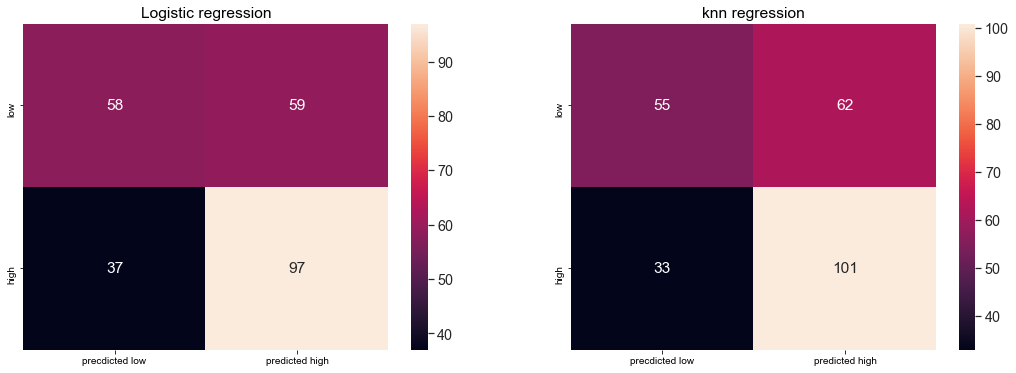

In [12]:
import seaborn as sns
fig,ax=plt.subplots(1,2,figsize=(18,6))
dfk= pd.DataFrame(cmk_test,index =['low','high'],columns=['precdicted low','predicted high'])
df= pd.DataFrame(cm,index =['low','high'],columns=['precdicted low','predicted high'])
sns.set(font_scale=1.3)
sns.heatmap(df.iloc[-1::-1,:], annot=True,fmt= 'g', ax = ax[0])
ax[0].set_ylim([0,2]);
ax[0].set_title('Logistic regression')
sns.heatmap(dfk.iloc[-1::-1,:], annot=True,fmt= 'g', ax = ax[1])
ax[1].set_ylim([0,2]);
ax[1].set_title('knn regression')

In [13]:
recall = (cm[1][1])/cm.sum(axis=1)[1]
print(recall)
print('recall/Sensitivity= TP/TP+FP')

0.7238805970149254
recall/Sensitivity= TP/TP+FP


In [14]:
specificity = cm[1][1]/(cm[1][1]+cm[0][1])
specificity

0.6217948717948718

In [15]:
specificity_new = cm[1][1]/cm.sum(axis=0)[1]
specificity_new

0.6217948717948718

In [16]:
precision = cm[1][1]/cm.sum(axis=0)[1]
precision

0.6217948717948718

In [17]:
f1_score = (2*precision*recall)/(recall+precision)
f1_score

0.6689655172413793

In [18]:
print(classification_report(y_test,logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.50      0.55       117
           1       0.62      0.72      0.67       134

    accuracy                           0.62       251
   macro avg       0.62      0.61      0.61       251
weighted avg       0.62      0.62      0.61       251



In [19]:
def plot_roc(test,logprobs,knnprobs,axis):
    fpr, tpr, thresholds = roc_curve(test, logprobs)
    kfpr, ktpr, kthresholds = roc_curve(test, knnprobs)
    ax.plot(fpr, tpr, label=f'Logistic Regression (area = {logreg_auc:.2f})', color = 'b')
    ax.plot(kfpr, ktpr, label=f'KNN (area = {knnreg_auc:.2f})', color = 'g')  
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.4,
    )
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    ax.legend(loc="lower right")


NameError: name 'logreg_auc' is not defined

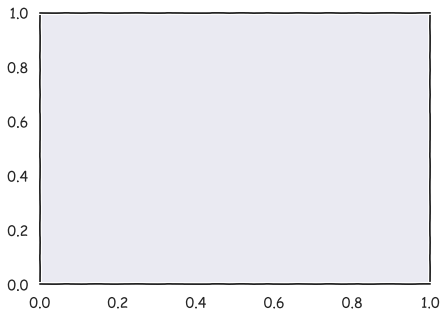

In [21]:
plt.xkcd(randomness=0,scale=0.1)
y_probs = logreg.predict_proba(X_test)[:,1]
y_kprobs = knnreg.predict_proba(X_test)[:,1]
fig, ax = plt.subplots(figsize = (7,5))
fig.patch.set_facecolor('None')
fig.patch.set_alpha(0)
plot_roc(y_test,y_probs,y_kprobs,ax)
[ax.spines[key].set_visible(False) for key in ax.spines.keys() if key not in ['bottom','left']];
ax.patch.set_facecolor('None')
ax.patch.set_alpha(0)
plt.tight_layout()
